In [2]:
import pandas as pd
import numpy as np
import csv

# library for storing and loading objects
import pickle

# library for stemming work
import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# library used to make inverted index
from collections import defaultdict
from collections import Counter

# cosine distance
from scipy.spatial.distance import cosine

import math 

# heap_max library
import heapq
from heapq import heappush, heappop

from geopy.geocoders import Nominatim
from geopy import distance
import folium

import functions

# variable declarations
path1 = 'data/docs/'
path2 = '.tsv'
#stemmed_path='data/tokenized_docs/'
#sp = string.punctuation+'“”–’'

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alessandra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alessandra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Step 2: Create documents
    - Importing data from Airbnb_Texas_Rentals.csv and preparing it for pre processing

In [270]:
texas1 = pd.read_csv("data/Airbnb_Texas_Rentals.csv")
texas1 = texas1.drop(['Unnamed: 0'], axis=1)
texas1 = texas1.drop_duplicates()
texas1 = texas1[np.isfinite(texas1['latitude'])]
texas1 = texas1[np.isfinite(texas1['longitude'])]


For every structure we created, we stored them as remote. You cannot find the inverted indexes inside the Github link.

We done the preprocessing to create the tsv files.

We created vocabulary parsing every document and updating it when the algorithm finds a new word. 

In [3]:
from importlib import reload
reload(functions)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alessandra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alessandra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<module 'functions' from 'C:\\Users\\Alessandra\\Documents\\ADM\\HW3\\ADM18-HW3-Group29\\functions.py'>

# Step 3: Search Engine

### 3.1.1) Preprocessing

Store rows of dataframe as separate tsv files into a folder

In [12]:
functions.preprocessing(texas1)

### Creating the vocabulary and the inverted index 1

We decided to create the vocabulary and inverted index 1 into the same methods because it's faster... 

vocabulary structure: { word : id }

Our representation of vocabulary is for move and get the id for each term easily.
The inverted index 1 is been created as asked. 
It returns, given the query, a list of documents in which all the words of the query are contained.

In [13]:
functions.create_vocabulary_and_ii1(texas1)

## 3.1) Search engine 1

In [127]:
reload(functions)

[nltk_data] Downloading package punkt to /Users/miguel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/miguel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<module 'functions' from '/Users/miguel/Desktop/HW3/ADM18-HW3-Group29/functions.py'>

In [128]:
res = functions.search_engine_1('House with garden')
res

,Title,Description,City,Url
1,Zen & the Art of the Ranch House,A much-loved family home nestled in a serene g...,Irving,https://www.airbnb.com/rooms/11502964?location...
2,The Fortress for your comfort.,The Fortress is a two story ranch style house ...,Austin,https://www.airbnb.com/rooms/11160635?location...
3,GraceGardens: Rustic Oak Cabin,Enchanting retreat on the San Marcos River in ...,Martindale,https://www.airbnb.com/rooms/964091?location=B...
4,"Rosen House Inn, Rose Garden Room",We are a small family owned Bed and Breakfast ...,Fort Worth,https://www.airbnb.com/rooms/9972447?location=...
5,Arlington Heights Guest House Cottage,"Bright,Open and Airy Cottage. Great location t...",Fort Worth,https://www.airbnb.com/rooms/18557788?location...


## 3.2) Conjunctive query & Ranking score

### 3.2.1) Inverted index

In [5]:
functions.inverted_index_TFIDF(texas1)

### 3.2.2) Execute the query

We decided to create the second search engine basing on the inverted indexes already built, cutting them: 
the purpose is that, in this way, we have less computation than to compute everything.
Thus, every time we have a new query, the method generates 2 different inverted indexes, sliced for the query needs.

In this way, we won't need a big numpy array for the query and each document considered for making the cosine similarity (for this we exploited the second inverted index) ; in fact, vectors for computing cosine similarity will be exactly long like the length of the query. 
Query will have 1 for each element and doc vector will have each tfidf for each term of the query.

$$ 1-cosine(\text{doc array for the query},\text{array of query}) $$

will compute the Cosine Similarity



In [132]:
res = functions.search_engine_2('Beach, two rooms with private bathroom')
res

5

# Step 4: Define a new score!

### 'search_engine_3' is the function which assigns ranking for each retrieved document, basing on extra information given in input by users. 

At first, we will make the same as we have done in the question 3.1 with Search Engine 1, that brings documents that satisfy a text query. 
Moreover, besides a text query, now it's allowed the users to input a desired price, the number of rooms needed and, last but not least, the desired location. 
These are the attributes with which documents will be evaluated, documents that firstly came out from the search engine 1.
To make the ranking, each attribute we considered has a different importance. For this case, the location has the highest priority. Following for ranking, price and then the number of rooms have been considered. 

Each rank per document go from 0 to 1.



### In terms of scoring by each information, we create functions to give the score to each different document. 

#### Target price : ( Function name is 'price_rank' )

We score the low point if the difference between the target price that users prefer and price of documents is big. 

We decide to make the score as a linear function that decrease linearly with the absolute difference between target price and document price with slope of 0.01. 
In this case we are able to spread ranks related to the target price in a very smooth way. Since we want a rank value between 0 and 1, we had to define properly the domain of our function. 

$$ \text{price_rank}_\text{doc_i} = 1 - \frac{1}{100} \times \left| \text{ price_target} - \text{price_doc_i } \right| $$

As consequence of this decision, in case the difference of price between the preferred price for the user and a high price of the document considered is equal or greater than 100, then it's not given any positive score to the price, so the score is 0.   


## Example of the trend of a preferred price fixed

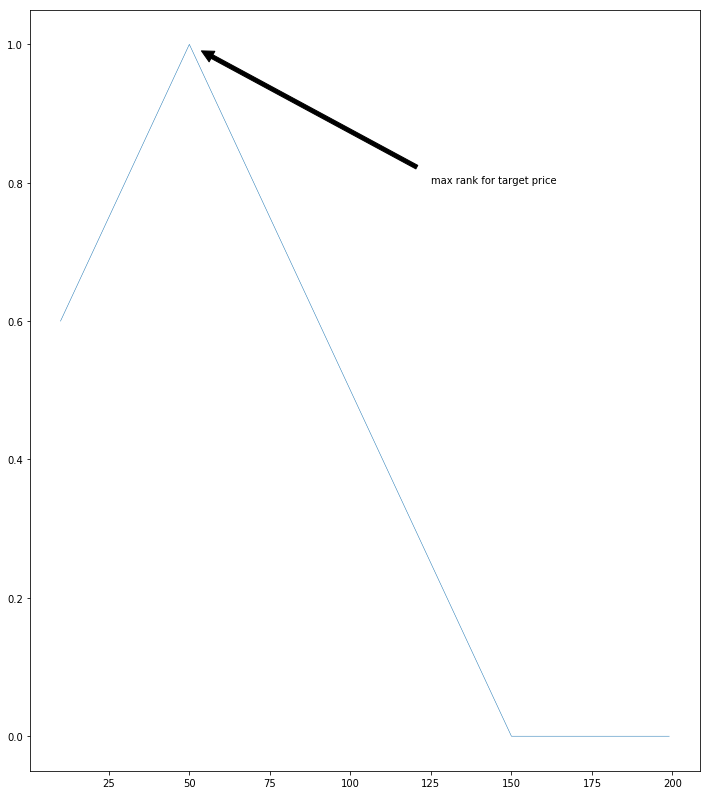

In [22]:

my_price=50

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 14))
plt.plot([float(integer) for integer in range(10, 200, 1)], [float(functions.price_rank(my_price,integer)) for integer in range(10, 200, 1)], lw=0.5)
plt.annotate('max rank for target price', xy=(50, 1), xytext=(125, 0.8),
            arrowprops=dict(facecolor='black', shrink=0.05)
            )
plt.show()

#### The number of rooms:  ( Function name is 'rooms_rank' )

For this case, we assign each point according to the difference between the number of rooms that users need and the number of rooms that the document has. 

In addiction, this difference gives us how much the document (post Airbnb) fits with the users needs.

We assumed:
- More rooms a document has, less probability the post Airbnb has to be interesting to users.
- The value "Studio" into bedrooms field into the csv, could be a single room. 

#### Location : ( Function name is 'distance_rank' ) 

The function gives points depending on the distance from the location desired to the bnb. 

$$ Library : Geopy $$
Geopy is a good tool to compute the latitude and longitude, given an address or a city.

Once we find out the values of locations (location that user needs and all the locations referred to documents) , the function that returns points is as follows. 

$$  \text{location_rank}_\text{doc_i}  = 1 -  \frac{\text{distance}}{1 + \text{distance}}$$

Further the distance is, lower the point goes down. 
Therefore, we applied this function because it goes smoothly to 0 from 1 asymptotically. 
We computed the value 1 - function as rank, to get results inversely proportional to the radius. 

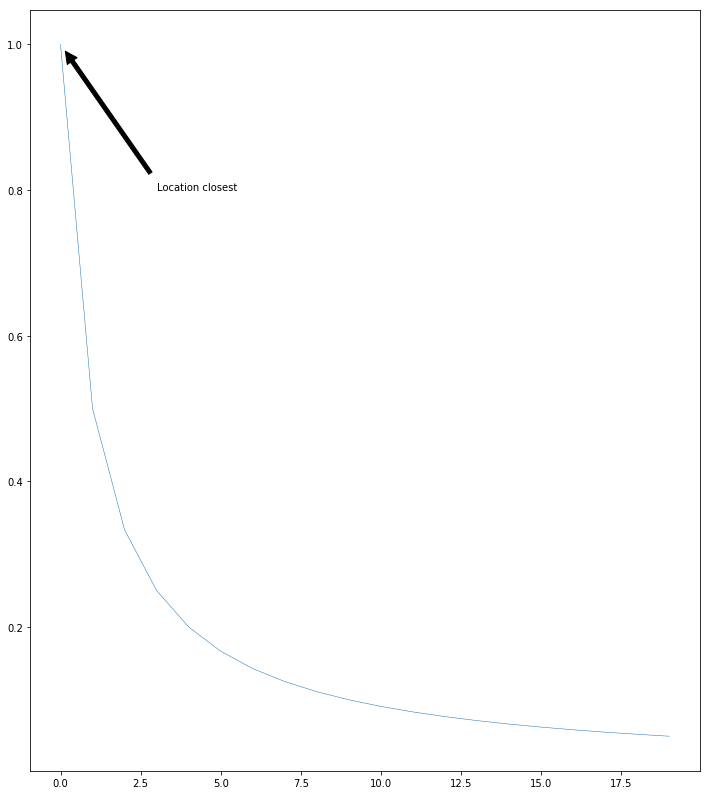

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 14))
plt.plot([float(integer) for integer in range(0, 20, 1)], [float(1-(integer/(1+integer))) for integer in range(0, 20, 1)], lw=0.5)
plt.annotate('Location closest', xy=(0, 1), xytext=(3, 0.8),   arrowprops=dict(facecolor='black', shrink=0.05),            )
plt.show()

In [15]:
res = functions.search_engine_3(input('What are you looking for: '))
res

What are you looking for: nice room
target price:
50
n rooms:
1
location
Dallas
Found 372 results


,Ranking,Title,Description,City,Url
0,1,Nice & spacious room in Deep Ellum,Modern contemporary town home centrally locate...,Dallas,https://www.airbnb.com/rooms/16855128?location...
1,2,Nice & spacious room in Deep Ellum,Modern contemporary town home centrally locate...,Dallas,https://www.airbnb.com/rooms/16855128?location...
2,3,Nice & spacious room in Deep Ellum,Modern contemporary town home centrally locate...,Dallas,https://www.airbnb.com/rooms/16855128?location...
3,4,Nice & spacious room in Deep Ellum,Modern contemporary town home centrally locate...,Dallas,https://www.airbnb.com/rooms/16855128?location...
4,5,Cozy cottage home near Bishop Arts,"A nice, cosy English-styled cottage house that...",Dallas,https://www.airbnb.com/rooms/16554106?location...


# Step 4: make nice visualization

In [364]:
functions.houses_map(input('Location: '), float(input('radius(km): ')))

Location: San Antonio
radius(km): 3
